#**Importation des bibliothèques**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,mean_squared_error,r2_score

#**Chargement de la dataset**

Notre dataset contient des informations médicales sur des patients, avec pour objectif de prédire si un patient a une maladie cardiaque (HeartDisease).En fonction des données médicales d’un patient, prédire s’il a une maladie cardiaque. Ce qui est utile pour aider les médecins à détecter tôt les risques.





In [ ]:
df = pd.read_csv("heart.csv")
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


#**Prétraitement**

##Remplissage des valeurs manquantes
Si une cellule est vide (NaN), on la remplit avec la moyenne si la valeur est numérique , et avec le mod (la valeur la plus répétée) si la valeur est catégorielle.

In [ ]:
# Remplissage des valeurs null
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

On transforme les colonnes non numériques (textuelles): **['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']** en valeurs numériques pour que les modèles puissent les utiliser,car ils ne comprennent que des nombres, donc on utilise LabelEncoder, On encode chaque colonne individuellement dans une boucle.





In [ ]:
# Encodage des variables catégorielles
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

#**Split**

On divise les données :

* 85% pour l’entraînement

* 15% pour le test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#**Définition du modèle**

##Définition et entrainement du modèle

Random Forest gère très bien le mélange de types différent de données: variables numériques et catégorielles et capte les relations non linéaires sans prétraitement complexe . Car il entraîne plusieurs arbres indépendamment et puis il donne la moyenne leurs résultats , cela rend le modèle robusste : moins sensible au bruit , et diminue le risque de surapprentissage que les arbres simples.

In [ ]:
model = RandomForestClassifier(n_estimators= 1000, min_samples_split= 10, min_samples_leaf= 2, max_depth= 30)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000)

##Afficher l'importance des features dans le modèle
Le graphe ce dessous montre quelle part chaque variable de la dataset a plus d'importance dans la prédiction de la maladie cardiaque, selon le modèle.
**model.feature_importances_** est un attribut spécifique aux arbres de décision (RandomForestClassifier)

On crée un tableau pandas.DataFrame qui a :

* Une colonne "Feature" contenant les noms des variables (venant de X.columns)

* Une colonne "Importance" contenant les valeurs d’importance issues du modèle.

On trie le DataFrame en ordre décroissant d’importance (du plus important au moins important).Cela permet de visualiser les variables les plus influentes en premier.

Plus une feature a une importance élevée, plus elle a contribué à améliorer les performances du modèle. Les top 4 caractéristiques importants :
* ST-Slop :Pente du segment ST (type d’onde dans ECG).
* ChestPainType : Type de douleur thoracique (typique, atypique).
* Oldpeak: Dépression ST induite par l’exercice.
* Cholesterol : Taux de cholestérol (mg/dl)	.

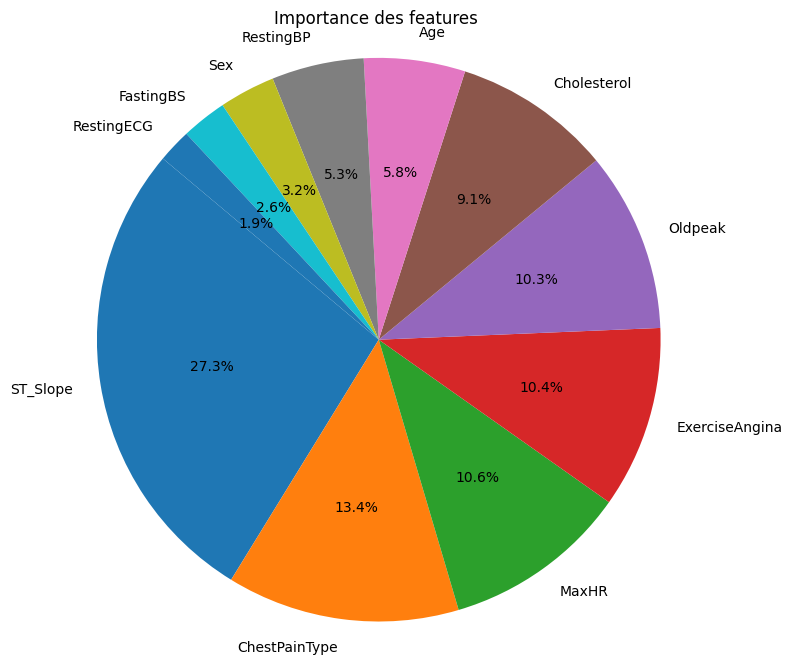

In [ ]:
#Affichage des importances des features
features = X.columns   # on récupère la liste des noms des colonnes

importances = model.feature_importances_

# Création d'un dataFrame trié par importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(8,8))
plt.pie(importance_df['Importance'], labels=importance_df['Feature'], autopct='%1.1f%%', startangle=140)
plt.title("Importance des features ")
plt.axis('equal')  # Pour un cercle parfait
plt.show()

In [ ]:
params = {
    'n_estimators': [50, 100,1000],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=params,
    n_iter=20,
    cv=3
)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy sur test :", accuracy_score(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30}
Accuracy sur test : 0.8840579710144928
Matrice de confusion :
 [[50  6]
 [10 72]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        56
           1       0.92      0.88      0.90        82

    accuracy                           0.88       138
   macro avg       0.88      0.89      0.88       138
weighted avg       0.89      0.88      0.88       138



##**Evaluation du modèle**

On fait une prédiction sur les données test.
* Accuracy : Pourcentage de bonnes prédictions sur l’ensemble de test.

* Precision : Parmi les prédictions positives, combien sont correctes

* Recall : Parmi les vrais positifs, combien ont été trouvés

* F1-score : Moyenne harmonique entre précision et rappel

* Support : Nombre de cas par classe

* Confusion matrix : Montre combien de vrais positifs / faux positifs / vrais négatifs / faux négatifs.



In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9130434782608695
Confusion Matrix:
 [[63  5]
 [ 7 63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        68
           1       0.93      0.90      0.91        70

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[0]]
print("Prédiction :",model.predict(echantillon))
print("Valeur réelle :",y_test.iloc[0])

Prédiction : [0]
Valeur réelle : 0


#**Comparaison avec d'autres modèles de classification**

##Naive Bayes

On utilise GaussienNB dans cette dataset , car les valeurs sont numériques continues  (age , cholesterol, etc ...) .

In [ ]:
model_nv= GaussianNB()
model_nv.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Évaluation Naive Bayes:
y_pred = model_nv.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8623188405797102
Confusion Matrix:
 [[61  7]
 [12 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        68
           1       0.89      0.83      0.86        70

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[0]]
print("Prédiction :",model_nv.predict(echantillon))
print("Valeur réelle :",y_test.iloc[0])

Prédiction : [0]
Valeur réelle : 0


##KNN

In [ ]:
k=5
knn_model=KNeighborsClassifier(k)
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [ ]:
# Évaluation KNN:
y_pred = knn_model.predict(X_test)
acc_knn= accuracy_score(y_test, y_pred)
print("Accuracy:",acc_knn)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7028985507246377
Confusion Matrix:
 [[35 23]
 [18 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63        58
           1       0.73      0.78      0.75        80

    accuracy                           0.70       138
   macro avg       0.69      0.69      0.69       138
weighted avg       0.70      0.70      0.70       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[1]]
print("Prédiction :",model_ada.predict(echantillon))
print("Valeur réelle :",y_test.iloc[1])

Prédiction : [1]
Valeur réelle : 1


##Decision Tree

In [ ]:
model_dt= DecisionTreeClassifier(max_depth=5,random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Évaluation Decision Tree:
y_pred = model_dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.855072463768116
Confusion Matrix:
 [[61  7]
 [13 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        68
           1       0.89      0.81      0.85        70

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.85       138
weighted avg       0.86      0.86      0.85       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[0]]
print("Prédiction :",model_dt.predict(echantillon))
print("Valeur réelle :",y_test.iloc[0])

Prédiction : [0]
Valeur réelle : 0


##Adaboost

In [ ]:
#classifieur faible
weak_classifier=DecisionTreeClassifier(max_depth=4)
#modèle adaboost
model_ada=AdaBoostClassifier(estimator=weak_classifier,n_estimators=10)
model_ada.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=10)

In [ ]:
# Évaluation Adaboost:
y_pred = model_ada.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8840579710144928
Confusion Matrix:
 [[63  5]
 [11 59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        68
           1       0.92      0.84      0.88        70

    accuracy                           0.88       138
   macro avg       0.89      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[0]]
print("Prédiction :",model_ada.predict(echantillon))
print("Valeur réelle :",y_test.iloc[0])

Prédiction : [0]
Valeur réelle : 0


##Regression Logistique

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Évaluation Reg Logistique:
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8840579710144928
Confusion Matrix:
 [[61  7]
 [ 9 61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88        68
           1       0.90      0.87      0.88        70

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[0]]
print("Prédiction :",logreg.predict(echantillon))
print("Valeur réelle :",y_test.iloc[0])

Prédiction : [0]
Valeur réelle : 0


##SVM

In [ ]:
svm_model=SVC(kernel='linear')
svm_model.fit(X_train,y_train)

SVC(kernel='linear')

In [ ]:
# Évaluation SVM:
y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8478260869565217
Confusion Matrix:
 [[47 11]
 [10 70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82        58
           1       0.86      0.88      0.87        80

    accuracy                           0.85       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.85      0.85      0.85       138



In [ ]:
#prédiction sur un échantillon
echantillon = X_test.iloc[[2]]
print("Prédiction :",svm_model.predict(echantillon))
print("Valeur réelle :",y_test.iloc[2])

Prédiction : [1]
Valeur réelle : 1


#**Interface web**

On commence par importer la bibliothèque joblib , pour sauvegarder notre modèle RF dans un fichier .pkl pou l'utiliser sans besoin de le réentrainer à chaque fois.

In [ ]:
import joblib

joblib.dump(model, 'model/heart_model.pkl')


['model/heart_model.pkl']

On installe la bibliothèque pyngrok qui permet d'utiliser Ngrok directement en Python , sans ligne de commande

In [ ]:
!pip install pyngrok

* ngrok est un outil qui crée un tunnel sécurisé entre l'ordinateur (ou serveur) et Internet.
* Pour utiliser ngrok avec toutes ses fonctionnalités (comme dans notre cas exposer un serveur local sur Internet avec une URL publique unique), on doit tout d'abord s’inscrire sur le site ngrok et récupérer un jeton d’authentification appelé authtoken.
* La commande ci dessous sert à configurer le jeton authtoken.




In [ ]:
!ngrok config add-authtoken 2xtnFnj3yKJwDZKttUNuTK5MOY9_88SPjCYZF9syuzLoFRWqm

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


##**Exécuter notre interface**

##Explication app.py
* Flask : framework pour créer une application web.

* render_template_string : permet d’afficher une page HTML définie dans une chaîne de caractères.

* request : permet de récupérer les données envoyées via un formulaire HTML.

* pyngrok : crée un tunnel public vers notre application Flask locale (utile pour tester dans Colab).

* pandas : utilisée ici pour convertir les données saisies en DataFrame.

* joblib.load(): Charge notre modèle de prédiction ( RandomForestClassifier) enregistré dans le fichier .pkl.
* le bloc html (html = """ ... """) :Contient un formulaire avec 11 champs de saisie (pour les 11 features).
* value="{{ filled_values['feature' + loop.index|string] if filled_values is defined else '' }}" : Les champs conservent leur valeur après la soumission du formulaire.
* Après soumission, le résultat de la prédiction s’affiche .
* Quand on ouvre la page, la fonction home() s’exécute et affiche le formulaire vide.
* La fonction predict () récupère les 11 valeurs du formulaire (feature1, ..., feature11), les convertit en float.
* df_features = pd.DataFrame([features], columns=feature_names):
 Crée une DataFrame avec les valeurs pour les donner au modèle,et on utilise le modèle pour faire la prédiction.
* filled_values = {f'feature{i}': features[i-1] for i in range(1, 12)} : cette ligne crée un dictionnaire avec les anciennes valeurs pour les réafficher dans les inputs HTML.
* On affiche le formulaire avec les champs remplis + la prédiction.
* Les 3 dernières lignes : Ouvrent un tunnel avec ngrok :donne une URL publique.
* Enfin ,on lance l'app Flask en local sur le port 5000.












In [ ]:
!python app.py

 * ngrok tunnel URL: https://1f3f-34-150-178-14.ngrok-free.app
 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Jun/2025 15:02:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 15:02:08] "GET /favicon.ico HTTP/1.1" 404 -
Prediction: 0
127.0.0.1 - - [01/Jun/2025 15:02:46] "POST /predict HTTP/1.1" 200 -
Prediction: 0
127.0.0.1 - - [01/Jun/2025 15:03:15] "POST /predict HTTP/1.1" 200 -
Prediction: 0
127.0.0.1 - - [01/Jun/2025 15:03:24] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 15:03:30] "GET / HTTP/1.1" 200 -
Prediction: 1
127.0.0.1 - - [01/Jun/2025 15:04:23] "POST /predict HTTP/1.1" 200 -
^C
